<a href="https://colab.research.google.com/github/v-zeng/data_mining_grad_projects/blob/main/CISC873_DM_F21_A5_zeng_vinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Anti-cancer activity prediction**

Student: Vinson Zeng

Student #: 05550960

**✔️ Meme competition:**
Include/find a MEME that you liked related to data science/data mining/machine learning

![](https://drive.google.com/uc?export=view&id=1Gu5RoRHStk-T1Q1lgcEFUmGDlUxheUu6)


**What is the experimental protocol used and how was it carried out? How did we tune hyper-parameters in the template? What is the search space and what is the criteria to determine good/bad hyper-parameters?**

Our model performs binary graph classification using a Graph Convolutional Network (GCN) . It takes a molecular structure and classifies it into one of two categories. The model first reads in a spatial data file (SDF) which contains structural information for chemical compounds. Each compound is represented as a graph, with atoms as nodes and bonds as edges. The data is parsed based on nodes, edges, and labels (positive or negative against non-small cell lung cancer). The model creates embeddings for each node and integrates the initial feature vectors and information about local graph structures surrounding them. Embeddings are updated using message passing, in which graph nodes exchange information with neighbouring nodes and ultimately update their embedding layer after each layer. Message passing involves the aggregation of vectors from neighbouring nodes and outputting a message vector, which is used to construct a new vector (features are summed). The template model uses the default Relational Graph Convolutional Networks (RGCN) message passing mechanism. The updated node representations after the GCN layers then have their means computed along defined segments for the nodes. The computed mean vectors are then classified using a dense layer with a sigmoid activation feature.

In the template we tune hyper-parameters using trial and error and/or using default hyperparameters. For example, we set the parameter ‘hidden_dim’ to 32 in the template and use the rest of the default hyperparameters.

The search space depends on the parameter. Some have limited options, such as ‘message_calculation_class’ (GGNN, RGCN, RGAT, RGIN, GNN-Edge-MLP, GNN-FiLM), while some search spaces could be difficult to define the domain, such as ‘hidden_dim’. A good hyper-parameter would improve model performance by increasing the true positive rate and decreasing the false positive rate, both of which would increase the AUC score.


**✔️ Problem Formulation:**
Define the problem. What is the input? What is the output? What data mining function is required? What could be the challenges? What is the impact? What is an ideal solution?

The problem is to determine whether a chemical compound is positive or negative against non-small cell lung cancer (anticancer activity prediction). The inputs are chemical compounds, which are represented as a graph. The outputs are predictions of 0 (negative) or 1 (positive). Classification is the data mining function required. Challenges could include finding optimal hyperparameters, imbalanced data, over-smoothing. Sub-optimal hyperparameters could result in poor learning of the model, which would lead to poor predictive/classification performance. Imbalanced data can also result in poor model training and misleading results, such as predicting the majority class for each output. If there are too many layers in the GNN, the node representations could become too similar and therefore result in poor predictions from the model.

**✔️ Answer the questions below (briefly):**

**🌈Based on the provided template, describe the format of the input file (sdf file).**

The input file contains structural information for chemical compounds. The file contains the atoms (nodes) in each molecule, positions, node features, and bonds among the atoms (edges). There are multiple compounds which are delimited by lines consisting of four dollar signs.

**🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size?)?**

‘Data’ is the feature matrix (all nodes) and is of shape (None,). None is represented by batch_size * max_nodes_per_graph. Batch size is the number of graphs in a batch and max_nodes_per_graph is the total number of nodes in the batch. Batch shape of None means a dynamic shape, and here ‘data’ uses the node label as the value.

The feature matrix (‘data’) is passed to the embedding layer, in which it becomes a  tensor of shape (None,20); None is represented by batch_size * max_nodes_per_graph and 20 is a vector of 20 numbers.

‘Edges’ are a matrix of shape (None,2). None refers to the total number of edges for a batch, 2 for integers of source and destination (start and end nodes).’Node2grah’ is the node to graph matrix of shape (None,) and uses the graph ids/index of the graph. None is represented by batch_size*max_nodes_per_graph.

**🌈For each dim of gnn_out, what does it represent? For each dim of avg, what does it represent?**

For gnn_out, it has a shape (None,32). None is represented by batch_size*max_nodes_per_graph. 32 represents the size of the output of the hidden dimensions. For avg, it has a shape (None,32). None for avg is represented by batch_size (number of graphs). The 32 for avg is the vector representation for each node.

**🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it represent?**
For segment_mean, it computes the mean of each defined segment (segment_id) along a tensor - output is a tensor with the mean of each segment. For tf.reduce_mean, it reduces the input tensor along the dimensions specified in ‘axis’ by computing the mean of elements across the ‘axis’ dimensions. For pred, it has a shape (None,1). None is represented by batch_size (number of graphs) and 1 is the class label, which is the numeric output of the sigmoid activation function between 0 and 1.

**🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**
Graphs perform message passing between nodes (aka neighbourhood aggregation). The idea is to push messages (embeddings) from surrounding nodes around a reference node through the connected edges. With more layers there will be more pushing and each node will contain more information about their own features and neighbouring nodes. The template uses ‘num_layers’ of 4, which is the default.



### **Template**

## Read SDF format data (structured-data format)

In [ ]:
# change working directory
%cd /content/drive/MyDrive/CISC873_A5_Data
!pwd

/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


In [ ]:
# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0




In [ ]:
from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data
training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
testing_set  = read_sdf('test_x.sdf') # read in testing data

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
print(training_set[1]) # print index 1 of training data

(['Cl', 'O', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0, 11],
       [ 1,  3],
       [ 1,  5],
       [ 2,  3],
       [ 2,  7],
       [ 3,  4],
       [ 4,  6],
       [ 5,  8],
       [ 6,  8],
       [ 7,  9],
       [ 9, 10],
       [10, 11]]), 0)


## Visualizing/Inspecting a Sample

In [ ]:
# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

In [ ]:
def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

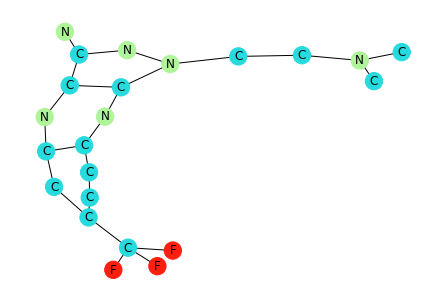

In [ ]:
plt.clf() # clear current figure
visualize(training_set[20]) # draw graph for index 20 of training set

## Preprocessing:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4): # for a batch in iterator object
    for k,v in train_batch[0].items(): # for key, value in train_batch view object
        print(k) # print keys
        print(v) # print values
        pass # null statement
    print('label', train_batch[1]) # print 'label' and train_batch index 1
    break # terminate loop

data
[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
edges
[[  0   6]
 [  1   8]
 [  1  13]
 [  2   8]
 [  3  11]
 [  3  14]
 [  4  11]
 [  5   6]
 [  5   8]
 [  5   9]
 [  5  12]
 [  6   7]
 [  7  10]
 [  7  11]
 [  9  10]
 [ 13  15]
 [ 47  57]
 [ 48  59]
 [ 49  61]
 [ 50  70]
 [ 51  57]
 [ 51  59]
 [ 51  60]
 [ 52  54]
 [ 52  58]
 [ 53  61]
 [ 53  65]
 [ 54  70]
 [ 55  70]
 [ 56  57]
 [ 56  58]
 [ 56  61]
 [ 58  59]
 [ 60  62]
 [ 60  63]
 [ 62  64]
 [ 63  67]
 [ 64  66]
 [ 64  72]
 [ 65  68]
 [ 65  69]
 [ 66  67]
 [ 66  75]
 [ 68  71]
 [ 69  74]
 [ 71  73]
 [ 71  76]
 [ 73  74]
 [ 73  77]
 [ 94 101]
 [ 94 108]
 [ 95 103]
 [ 95 104]
 [ 96 104]
 [ 96 112]
 

In [ ]:
!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

In [ ]:
# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)

# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

In [ ]:
import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

1330/1330 [==============================] - 24s 15ms/step - loss: 0.2274 - auc: 0.5021 - val_loss: 0.2078 - val_auc: 0.5806
Epoch 2/5
1330/1330 [==============================] - 20s 15ms/step - loss: 0.2010 - auc: 0.6056 - val_loss: 0.1991 - val_auc: 0.5842
Epoch 3/5
1330/1330 [==============================] - 19s 15ms/step - loss: 0.1950 - auc: 0.6355 - val_loss: 0.1903 - val_auc: 0.6528
Epoch 4/5
1330/1330 [==============================] - 21s 16ms/step - loss: 0.1910 - auc: 0.6556 - val_loss: 0.1933 - val_auc: 0.6687
Epoch 5/5
1330/1330 [==============================] - 19s 15ms/step - loss: 0.1885 - auc: 0.6667 - val_loss: 0.1877 - val_auc: 0.6690


In [ ]:
# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions

[[0.11258012]
 [0.04928112]
 [0.03693643]
 ...
 [0.02312911]
 [0.02850211]
 [0.02810678]]


In [ ]:
len(y_pred) # length of predictions

12326

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

### Trial0

In this trial I will attempt to up-sample the minority positive class samples. It is a very unbalanced dataset and we're interested in performance on the minority class. I think that upsampling the minority class will help to improve the AUC score by increasing the true positive rate.

In [ ]:
# Trial0

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set
#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2530/2530 [==============================] - 40s 15ms/step - loss: 0.6256 - auc: 0.7055 - val_loss: 0.6049 - val_auc: 0.7374
Epoch 2/5
2530/2530 [==============================] - 37s 14ms/step - loss: 0.5925 - auc: 0.7510 - val_loss: 0.5776 - val_auc: 0.7677
Epoch 3/5
2530/2530 [==============================] - 37s 15ms/step - loss: 0.5805 - auc: 0.7680 - val_loss: 0.5693 - val_auc: 0.7770
Epoch 4/5
2530/2530 [==============================] - 36s 14ms/step - loss: 0.5684 - auc: 0.7799 - val_loss: 0.5691 - val_auc: 0.7854
Epoch 5/5
2530/2530 [==============================] - 37s 15ms/step - loss: 0.5569 - auc: 0.7901 - val_loss: 0.5560 - val_auc: 0.8004


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission0.csv')

### Trial1

Results from trial0:

Epoch 5/5
2530/2530 <br> - 37s 15ms/step<br> - loss: 0.5569<br> - auc: 0.7901<br> - val_loss: 0.5560<br> - val_auc: 0.8004

It appears the upsampling of the minority class did indeed improve the performance of the model, judging by the AUC score.

The current message passing mechanism is 'rgcn', which is the default. The primary difference between RGCN and GCN is that edges in RGCN can represent different relations. GCN uses weights that are shared by all edges in layer _l_, but in RGCN each edge type uses a different weight - edges of the same relation type use the same projection weight. In this trial I will configure the message passing style to Gated Graph Neural Networks (GGNN). GGNNs are an adaptation of GNNs which are suitable for non-sequential outputs. Long-term dependencies are encoded by node and edge gates, while long-term temporal dependencies are encoded by time gates. Gating makes the propagation model better (computing node representations). The primary modification of GNNs for GGNNs is the use of Gated Recurrent Units, unrolling the recurrence for a fixed number of steps, and using backpropagation through time to compute gradients. I predict there will be an improvement in the model performance due to the use of gating mechanisms in message passing.

In [ ]:
# Trial1

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'GGNN' # configure message passing style
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tenso

2530/2530 [==============================] - 74s 28ms/step - loss: 0.6117 - auc: 0.7250 - val_loss: 0.6058 - val_auc: 0.7705
Epoch 2/5
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5535 - auc: 0.7912 - val_loss: 0.5400 - val_auc: 0.8099
Epoch 3/5
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5292 - auc: 0.8131 - val_loss: 0.5262 - val_auc: 0.8212
Epoch 4/5
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5110 - auc: 0.8283 - val_loss: 0.4884 - val_auc: 0.8460
Epoch 5/5
2530/2530 [==============================] - 70s 28ms/step - loss: 0.4944 - auc: 0.8409 - val_loss: 0.4872 - val_auc: 0.8481


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission1.csv')

###Trial2

Results from trial1:

Epoch 5/5
2530/2530 <br> - 70s 28ms/step<br> - loss: 0.4944<br> - auc: 0.8409<br> - val_loss: 0.4872<br> - val_auc: 0.8481

The performance of the model appears to have improved using the GGNN message passing style. In this trial I will configure the message passing style to Relational Graph Attention Networks (RGAT). Graph attention networks use stacks of layers to attend over neighbors' features. Different weights can be specified for different nodes in a neighborhood without costly matrix operations or knowledge of graph structure upfront. Multi-head attention (specify number of heads) can be employed, in which _K_ independent attention mechanisms compute and then concatenate or average results for feature representation output.

I predict that the performance using RGAT will be an improvement over the default RGCN. However, I am not certain if it will outperform the GGNN configuration. I will likely attempt to tune the num_heads to see if more independent weight sums being computed will make a difference. I will start with num_heads = 1 and then try increasing it in subsequent trials.

In [ ]:
# Trial2

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'RGAT' # configure message passing style
params["num_heads"] = 1 # number of parallel/independent weight sums computed
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 356 kB 33.5 MB/s 
     |████████████████████████████████| 1.2 MB 44.9 MB/s 
     |████████████████████████████████| 129 kB 62.1 MB/s 
     |████████████████████████████████| 178 kB 70.5 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 3.6 MB 31.7 MB/s 
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=N

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 56s 20ms/step - loss: 0.6201 - auc: 0.7143 - val_loss: 0.5928 - val_auc: 0.7591
Epoch 2/5
2530/2530 [==============================] - 52s 20ms/step - loss: 0.5895 - auc: 0.7562 - val_loss: 0.5839 - val_auc: 0.7624
Epoch 3/5
2530/2530 [==============================] - 52s 20ms/step - loss: 0.5775 - auc: 0.7690 - val_loss: 0.5741 - val_auc: 0.7740
Epoch 4/5
2530/2530 [==============================] - 52s 20ms/step - loss: 0.5724 - auc: 0.7736 - val_loss: 0.5636 - val_auc: 0.7889
Epoch 5/5
2530/2530 [==============================] - 52s 20ms/step - loss: 0.5617 - auc: 0.7850 - val_loss: 0.5524 - val_auc: 0.7948


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission2.csv')

### Trial3

Results from trial2:

Epoch 5/5
2530/2530 <br>- 52s 20ms/step<br> - loss: 0.5617<br> - auc: 0.7850<br> - val_loss: 0.5524<br> - val_auc: 0.7948

The performance has not matched the GGNN message passing configuration. I will increase num_heads to 4 in this trial. I expect the performance to improve as the mode can learn different patterns with each head.

In [ ]:
# Trial3

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'RGAT' # configure message passing style
params["num_heads"] = 4 # number of parallel/independent weight sums computed
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions

/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 68s 25ms/step - loss: 0.6255 - auc: 0.7096 - val_loss: 0.6003 - val_auc: 0.7444
Epoch 2/5
2530/2530 [==============================] - 62s 25ms/step - loss: 0.5881 - auc: 0.7583 - val_loss: 0.5729 - val_auc: 0.7745
Epoch 3/5
2530/2530 [==============================] - 62s 24ms/step - loss: 0.5688 - auc: 0.7795 - val_loss: 0.5562 - val_auc: 0.7976
Epoch 4/5
2530/2530 [==============================] - 62s 24ms/step - loss: 0.5495 - auc: 0.7973 - val_loss: 0.5388 - val_auc: 0.8117
Epoch 5/5
2530/2530 [==============================] - 62s 25ms/step - loss: 0.5368 - auc: 0.8074 - val_loss: 0.5275 - val_auc: 0.8197


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission3.csv')

### Trial4

Results from trial3:

Epoch 5/5
2530/2530 <br> - 62s 25ms/step<br> - loss: 0.5368<br> - auc: 0.8074<br> - val_loss: 0.5275<br> - val_auc: 0.8197

There appears to be a slight improvement in the score using more heads. I will increase num_heads to 8 in this trial and expect a better performance again from the model.

In [ ]:
# Trial4

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'RGAT' # configure message passing style
params["num_heads"] = 8 # number of parallel/independent weight sums computed
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

2530/2530 [==============================] - 85s 31ms/step - loss: 0.6217 - auc: 0.7146 - val_loss: 0.6132 - val_auc: 0.7433
Epoch 2/5
2530/2530 [==============================] - 77s 31ms/step - loss: 0.5842 - auc: 0.7635 - val_loss: 0.5666 - val_auc: 0.7804
Epoch 3/5
2530/2530 [==============================] - 78s 31ms/step - loss: 0.5596 - auc: 0.7884 - val_loss: 0.5517 - val_auc: 0.7991
Epoch 4/5
2530/2530 [==============================] - 77s 30ms/step - loss: 0.5416 - auc: 0.8047 - val_loss: 0.5402 - val_auc: 0.8088
Epoch 5/5
2530/2530 [==============================] - 77s 30ms/step - loss: 0.5205 - auc: 0.8229 - val_loss: 0.5028 - val_auc: 0.8350


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission4.csv')

### Trial5

Trial4 results:

Epoch 5/5
2530/2530<br> - 75s 30ms/step<br> - loss: 0.5207<br> - auc: 0.8220<br> - val_loss: 0.4992<br> - val_auc: 0.8419

The submission/test score was  0.80120, which is similar to the previous trial. I think it would be okay at this point to prune some of the heads from the most recent trial. The configuration of num_heads=4 appears to be the best for now in regards to the GRAT message passing style.

In this trial I will explore the message passing mechanism of Relational Graph Isomorphism Networks (RGIN).

Graph isomorphism asks whether two graphs or networks that look different are actually the same - if they are topologically equivalent. Isomorphic graphs will have the same connectivity and differ in the node permutation. The Graph Isomorphism Network (GIN) generalizes the Weisfeiler-Lehman (WL) test to yield maximum discriminative power for Graph Neural Networks (GNN).

The WL test is based on iterative graph recolouring (discrete node/vertex relabeling). Each step involves aggregation of the node and neighbour colours into representative multisets which are then hashed into new unique colours. When there is stable colouring, the algorithm stops. At any point, different colourings between the graphs results in a non-isomorphic conclusion. However, colourings that are the same do not necesssarily mean the graphs are isomorphic.

GIN generalizes the WL test, in which the GNN learns to embed subtrees to low-dimensional space (Xu et al., 2019). This allows GNNs to capture dependencies between graph structures by learning to map similar graph structures to similar embeddings.

I predict RGIN will outperform the default 'rgcn' message passing style. However, I am not certain if it will outperform the GGNN trial - the best performing model so far in my trials.

In [ ]:
# Trial5

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 32 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'RGIN' # configure message passing style
params["num_aggr_MLP_hidden_layers"] = 2 # number of hidden layers of MLPs for aggregation of messages from neighbouring nodes
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2530/2530 [==============================] - 59s 22ms/step - loss: 0.6314 - auc: 0.6961 - val_loss: 0.5969 - val_auc: 0.7465
Epoch 2/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5889 - auc: 0.7551 - val_loss: 0.5761 - val_auc: 0.7773
Epoch 3/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5732 - auc: 0.7739 - val_loss: 0.5582 - val_auc: 0.7913
Epoch 4/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5572 - auc: 0.7902 - val_loss: 0.5382 - val_auc: 0.8186
Epoch 5/5
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5344 - auc: 0.8121 - val_loss: 0.5377 - val_auc: 0.8137


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission5.csv')

### Trial6

Results from trial5:

Epoch 5/5
2530/2530 <br>- 55s 22ms/stepv<br> - loss: 0.5344<br> - auc: 0.8121<br> - val_loss: 0.5377<br> - val_auc: 0.8137

The RGIN message passing style, with 'num_aggr_MLP_hidden_layers' = 2 seems to slightly outperform the default aggregation mechanism.

In this trial I will go back to the default message passing style of 'rgcn' and increase hidden_dim to 64. This increases the size of the output of all message passing layers. I predict that the performance will improve, as the model may be able to learn more with larger outputs from the message passing layers.

Subsequent trials:
-increase hidden_dim
-increase epochs for trials where loss has not stagnated
-use built-in model for graphBinaryClassificationTask

In [ ]:
# Trial6

# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 64 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=5, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2530/2530 [==============================] - 72s 27ms/step - loss: 0.6200 - auc: 0.7163 - val_loss: 0.5850 - val_auc: 0.7578
Epoch 2/5
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5860 - auc: 0.7604 - val_loss: 0.5723 - val_auc: 0.7926
Epoch 3/5
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5622 - auc: 0.7868 - val_loss: 0.5900 - val_auc: 0.8060
Epoch 4/5
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5334 - auc: 0.8136 - val_loss: 0.5212 - val_auc: 0.8295
Epoch 5/5
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5159 - auc: 0.8278 - val_loss: 0.4950 - val_auc: 0.8497


In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission6.csv')

### Trial7

Results from trial6:

Epoch 5/5
2530/2530 <br> - 70s 28ms/step<br> - loss: 0.5159<br> - auc: 0.8278<br> - val_loss: 0.4950<br> - val_auc: 0.8497

The performance of the model using the default message passing style of 'rgcn' has improved. Since the model did not appear to converge after 5 epochs (validation loss kept decreasing), I will increase the epochs to 10 in this trial. I expect the performance to again improve.

In [ ]:
# Trial7


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 64 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a larg

2530/2530 [==============================] - 73s 28ms/step - loss: 0.6206 - auc: 0.7157 - val_loss: 0.5929 - val_auc: 0.7536
Epoch 2/10
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5818 - auc: 0.7643 - val_loss: 0.6096 - val_auc: 0.7421
Epoch 3/10
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5603 - auc: 0.7858 - val_loss: 0.5698 - val_auc: 0.7967
Epoch 4/10
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5400 - auc: 0.8058 - val_loss: 0.5453 - val_auc: 0.8105
Epoch 5/10
2530/2530 [==============================] - 69s 27ms/step - loss: 0.5293 - auc: 0.8161 - val_loss: 0.5472 - val_auc: 0.8033
Epoch 6/10
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5183 - auc: 0.8247 - val_loss: 0.5212 - val_auc: 0.8282
Epoch 7/10
2530/2530 [==============================] - 70s 28ms/step - loss: 0.5103 - auc: 0.8314 - val_loss: 0.5109 - val_auc: 0.8372
Epoch 8/10
2530/2530 [==============================] - 70s

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission7.csv')

### Trial8

Results from trial7:

Epoch 7/10
2530/2530 <br> - 70s 28ms/step<br> - loss: 0.5103<br> - auc: 0.8314<br> - val_loss: 0.5109<br> - val_auc: 0.8372

Epoch 7 is where val_loss reaches a minumum before it begins to fluctuate, but the training loss keeps decreasing. I suspect there is overfitting sometime after this point. In this trial, I will increase the 'layer_input_dropout_rate' to 0.2. This sets the dropout rate during training for the input of each message passing layer. I think it mitigate some of the overfitting.

In [ ]:
# Trial8


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 64 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["layer_input_dropout_rate"] = 0.2 # set dropout rate for input of each message passing layer during training
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_indices:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_values:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/gradients/grad_ys_0_shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense

2530/2530 [==============================] - 82s 31ms/step - loss: 0.6210 - auc: 0.7142 - val_loss: 0.6135 - val_auc: 0.7434
Epoch 2/10
2530/2530 [==============================] - 78s 31ms/step - loss: 0.5908 - auc: 0.7555 - val_loss: 0.5900 - val_auc: 0.7620
Epoch 3/10
2530/2530 [==============================] - 79s 31ms/step - loss: 0.5689 - auc: 0.7808 - val_loss: 0.5548 - val_auc: 0.7910
Epoch 4/10
2530/2530 [==============================] - 78s 31ms/step - loss: 0.5527 - auc: 0.7955 - val_loss: 0.5320 - val_auc: 0.8174
Epoch 5/10
2530/2530 [==============================] - 79s 31ms/step - loss: 0.5384 - auc: 0.8091 - val_loss: 0.5358 - val_auc: 0.8183
Epoch 6/10
2530/2530 [==============================] - 79s 31ms/step - loss: 0.5268 - auc: 0.8189 - val_loss: 0.5189 - val_auc: 0.8302
Epoch 7/10
2530/2530 [==============================] - 79s 31ms/step - loss: 0.5177 - auc: 0.8262 - val_loss: 0.5032 - val_auc: 0.8392
Epoch 8/10
2530/2530 [==============================] - 79s

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission8.csv')

### Trial9

Results from trial8:

Epoch 10/10
2530/2530 <br>- 79s 31ms/step<br> - loss: 0.4946<br> - auc: 0.8432<br> - val_loss: 0.4772<br> - val_auc: 0.8592

The validation loss is able to reach lower than in the previous trial. However, it does begin to fluctuate very slightly within the same epoch range as previously. In this trial I want to go back and examine the the best performing model from previous trials using epoch=5. This trial will use the message passing mechanism of GGNN and have hidden_dim = 64. The validation loss was still decreasing steadily in trial1 (GGNN trial, epoch=5), so I predict this trial will likely achieve the best results.


In [ ]:
# Trial9


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 64 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'GGNN' # configure message passing style
params["layer_input_dropout_rate"] = 0.2 # set dropout rate for input of each message passing layer during training
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tenso

2530/2530 [==============================] - 127s 49ms/step - loss: 0.6045 - auc: 0.7309 - val_loss: 0.5676 - val_auc: 0.7730
Epoch 2/10
2530/2530 [==============================] - 124s 49ms/step - loss: 0.5478 - auc: 0.7943 - val_loss: 0.5119 - val_auc: 0.8269
Epoch 3/10
2530/2530 [==============================] - 126s 50ms/step - loss: 0.5080 - auc: 0.8299 - val_loss: 0.4995 - val_auc: 0.8400
Epoch 4/10
2530/2530 [==============================] - 125s 50ms/step - loss: 0.4627 - auc: 0.8636 - val_loss: 0.4456 - val_auc: 0.8849
Epoch 5/10
2530/2530 [==============================] - 127s 50ms/step - loss: 0.4257 - auc: 0.8866 - val_loss: 0.3911 - val_auc: 0.9076
Epoch 6/10
2530/2530 [==============================] - 127s 50ms/step - loss: 0.3909 - auc: 0.9050 - val_loss: 0.3662 - val_auc: 0.9199
Epoch 7/10
2530/2530 [==============================] - 126s 50ms/step - loss: 0.3613 - auc: 0.9185 - val_loss: 0.3276 - val_auc: 0.9351
Epoch 8/10
2530/2530 [==============================

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission9.csv')

### Trial10

Results from trial9:

Epoch 10/10
2530/2530 <br> - 127s 50ms/step<br> - loss: 0.2891<br> - auc: 0.9470<br> - val_loss: 0.2643<br> - val_auc: 0.9547

Looks like this is the best performing model so far. The validation loss constantly decreases through each epoch without fluctuating. I will increase hidden_dim to 128, which will increase the output of all message passing layers. I believe this will increase the amount of information in node embeddings and improve the learning and performance of the model.

In [ ]:
# Trial10


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 128 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'GGNN' # configure message passing style
params["layer_input_dropout_rate"] = 0.2 # set dropout rate for input of each message passing layer during training
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tens

2340/2340 [==============================] - 287s 121ms/step - loss: 0.5997 - auc: 0.7364 - val_loss: 0.5563 - val_auc: 0.7916
Epoch 2/10
2340/2340 [==============================] - 282s 120ms/step - loss: 0.5434 - auc: 0.7981 - val_loss: 0.5362 - val_auc: 0.8141
Epoch 3/10
2340/2340 [==============================] - 282s 121ms/step - loss: 0.5043 - auc: 0.8313 - val_loss: 0.5027 - val_auc: 0.8434
Epoch 4/10
2340/2340 [==============================] - 287s 122ms/step - loss: 0.4732 - auc: 0.8551 - val_loss: 0.4481 - val_auc: 0.8713
Epoch 5/10
2340/2340 [==============================] - 284s 121ms/step - loss: 0.4493 - auc: 0.8706 - val_loss: 0.4389 - val_auc: 0.8818
Epoch 6/10
2340/2340 [==============================] - 282s 121ms/step - loss: 0.4237 - auc: 0.8865 - val_loss: 0.4096 - val_auc: 0.8957
Epoch 7/10
2340/2340 [==============================] - 284s 121ms/step - loss: 0.4077 - auc: 0.8955 - val_loss: 0.4166 - val_auc: 0.9055
Epoch 8/10
2340/2340 [=======================

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission10.csv')

### Trial11

Results from trial10:

Epoch 10/10
2530/2530 <br> - 286s 113ms/step<br> - loss: 0.2666<br> - auc: 0.9543<br> - val_loss: 0.2651<br> - val_auc: 0.9550

The performance appears to have improved from increasing the hidden_dim to 128. The validation loss consistently decreases through the epochs without fluctuating.

In this trial I will increase gnn_num_layers from the default of 4 to 8.

In [ ]:
# Trial11


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 128 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'GGNN' # configure message passing style
params["layer_input_dropout_rate"] = 0.2 # set dropout rate for input of each message passing layer during training
params["gnn_num_layers"] = 8 # configure number of gnn layers
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0",

2530/2530 [==============================] - 287s 112ms/step - loss: 0.6104 - auc: 0.7259 - val_loss: 0.5667 - val_auc: 0.7791
Epoch 2/10
2530/2530 [==============================] - 287s 113ms/step - loss: 0.5394 - auc: 0.8038 - val_loss: 0.5206 - val_auc: 0.8312
Epoch 3/10
2530/2530 [==============================] - 286s 113ms/step - loss: 0.4870 - auc: 0.8470 - val_loss: 0.4871 - val_auc: 0.8520
Epoch 4/10
2530/2530 [==============================] - 287s 113ms/step - loss: 0.4584 - auc: 0.8668 - val_loss: 0.4309 - val_auc: 0.8845
Epoch 5/10
2530/2530 [==============================] - 288s 114ms/step - loss: 0.4170 - auc: 0.8916 - val_loss: 0.3886 - val_auc: 0.9071
Epoch 6/10
2530/2530 [==============================] - 289s 114ms/step - loss: 0.3821 - auc: 0.9098 - val_loss: 0.3829 - val_auc: 0.9128
Epoch 7/10
2530/2530 [==============================] - 285s 113ms/step - loss: 0.3528 - auc: 0.9233 - val_loss: 0.3673 - val_auc: 0.9300
Epoch 8/10
2530/2530 [=======================

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission11.csv')

### Trial12

Results from trial11:

Epoch 10/10
2530/2530 <br>- 286s 113ms/step<br> - loss: 0.3010<br> - auc: 0.9431<br> - val_loss: 0.3006<br> - val_auc: 0.9441

Increasing the number of gnn layers to 8 resulted in a slightly lower test score then trial 10. It's possible there is a slight bit of over-smoothing occuring, which happens when nodes have similar embeddings that do not have the same labels.

In this trial, I will go back to the trial10 model (GGNN, hidden_dim=128) and increase hidden_dim to 256.

In [ ]:
# Trial12


# import libraries
import numpy as np
from tqdm.notebook import tqdm

# create function to read sdf type file
def read_sdf(file): # param: file
    with open(file, 'r') as rf: # open file
        content = rf.read() # read file
    samples = content.split('$$$$') # return list of words in string using specified separator

    # create function to parse samples
    def parse_sample(s): # param: s
        lines = s.splitlines() # split string into list where each line is an element
        links = [] # create empty list for links
        nodes = [] # create empty list for nodes
        label = 0 # set 'label' variable to 0
        for l in lines: # iterate through lines
            if l.strip() == '1.0': # check condition: stripped line equivalant to '1.0'
                label = 1 # set label to 1
            if l.strip() == '-1.0': # check condition: if stripped line equivalant to '-1.0'
                label = 0 # set label to 0
            if l.startswith('    '): # check condition: line begins with specified value
                feature = l.split() # variable equals the list after string split by whitespace
                node = feature[3] # variable equals index 3 (fourth element of the 'feature' list)
                nodes.append(node) # append node to nodes list
            elif l.startswith(' '): # check condition: line begins with specified value
                lnk = l.split() # variable equals line split by whitespace
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes): # check condition: integer of lnk index 0 minus value of 1 is less than length of nodes variable
                    links.append(( # append to links list
                        int(lnk[0])-1, # integer of lnk index 0 minus 1
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label # return nodes list, links array, label

    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0] # return parsed samples for samples which have index 0 length greater than 0

#===============================================================================

from sklearn.model_selection import train_test_split # import function

training_set = read_sdf('train.sdf') # read in training data

# upsample minority class function==============================================
from sklearn.utils import resample # import resample function
def upsample_minority(training_set): # param: training_set

  # split training_set by minority and majority classes
  training_set_minority = [] # create empty list for minority class
  training_set_majority = [] # create empty list for majority class

  # iterate over list, separate positive and negative compounds against non-small cell lung cancer
  for i in training_set:
    if i[2] == 1: # if positive
      training_set_minority.append(i) # append sample to minority list
    else: # else (if negative)
      training_set_majority.append(i) # append sample to majority list

  # upsample minority class
  training_set_minority = resample(training_set_minority,
                                  replace=True, # sample with replacement
                                  n_samples=20242, # match majority class
                                  random_state=42) # for reproducibility

  # combine upsampled minority class with majority class
  training_set = training_set_majority + training_set_minority

  return training_set

#===============================================================================

training_set = upsample_minority(training_set) # upsample minority class

training_set, validation_set = train_test_split(training_set, test_size=0.15,random_state=42) # split data into training and validation sets

#===============================================================================

testing_set  = read_sdf('test_x.sdf') # read in testing data

#===============================================================================

# install package, load libraries and function
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50)) # set colormap

#===============================================================================

def visualize(sample): # visualize function; param: sample
    G=nx.Graph() # create empty graph without nodes or edges
    nodes = sample[0] # set nodes for sample
    edges = sample[1] # set edges for sample

    labeldict={} # create empty label dictionary
    node_color=[] # create empty node color list
    for i,n in enumerate(nodes): # for count, value of iteration
        G.add_node(i) # add node for count
        labeldict[i]=n # set count value for key
        node_color.append(colors[hash(n)%len(colors)]) # append color for node

    # a list of nodes:
    for e in edges: # iterate through edges
        G.add_edge(e[0], e[1]) # add edge between nodes

    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color) # draw network
    plt.show() # show network plot

    return G # return graph

#===============================================================================

## Preprocessing:

from tensorflow.keras.preprocessing.text import Tokenizer # import tokenizer class

max_vocab = 500 # set max vocabulary value
max_len = 100 # set max length


# build vocabulary from training set
all_nodes = [s[0] for s in training_set] # create list of nodes from index 0 of each sample in training set
tokenizer = Tokenizer(num_words=max_vocab) # specify max number of vocabulary words to use (100 most frequent words in this case)
tokenizer.fit_on_texts(all_nodes) # update internal vocabulary based on node list

#===============================================================================

from tensorflow.keras.preprocessing.sequence import pad_sequences # import function
import random # import module
random.seed(0) # set seed

# create single batch prep function
def prepare_single_batch(samples): # param: samples
    sample_nodes = [s[0] for s in samples] # create sample node list from index 0 of each sample
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes) # transform each sample in samples nodes to sequence of integers
    sample_nodes = pad_sequences(sample_nodes, padding='post') # add padding after each sequence
    max_nodes_len = np.shape(sample_nodes)[1] # set max nodes length as index 1 of sample node array
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] # create edges list, each element in list is created using sample element index 1 plus sample index multiplied by max_nodes_len
    edges = [e for e in edges if len(e) > 0] # keep edges elements with length greater than 0
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))] # create node to graph list, each element in list is created using index of sample multiplied by max_nodes_len

    all_nodes = np.reshape(sample_nodes, -1) # set all_nodes variable as reshaped sample_nodes array that contains same number of elements as old shape; let numpy calculate missing dimension
    all_edges = np.concatenate(edges) # set all_edges variable as joined sequences of edges

    node_to_graph = np.reshape(node_to_graph, -1) # reshape node_to_graph, let numpy calculate missing dimension
    return { # return results
        'data': all_nodes, # key: 'data', value: all_nodes
        'edges': all_edges, # key: 'edges', value: all_edges
        'node2grah': node_to_graph, # key: 'node2grah, value: node_to_graph
    }, np.array([s[2] for s in samples]) # array of sequence index 2 for each sample in samples


# generator function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True): # create function, params: dataset, batch_size=16, repeat=False, shuffle=True
    while True: # while loop
        dataset = list(dataset) # convert dataset to list
        if shuffle: # if condition = True
            random.shuffle(dataset) # shuffle list
        l = len(dataset) # length of dataset assigned to l
        for ndx in range(0, l, batch_size): # loop through indices in range 0 to length(dataset), stepsize=batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] # assign segment of list to batch_samples, slice from index to smaller of index + batch_size or length of dataset
            yield prepare_single_batch(batch_samples) # yield single batch successively (return value, maintain internal state)
        if not repeat: # if repeat = False
            break # terminate while loop

#===============================================================================

!pip install --quiet tf2_gnn # install module

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput # import layer, function

#===============================================================================

# import library, module, layers, classes
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,)) # the feature matrix is of shape batch_size*max_nodes_per_graph; batch shape of None means a dynamic shape, and no input after comma means it is 1 dimensional (single vector)

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32) # edges are a matrix of shape (none,2);None refers to total number of edges for batch, 2 for integers of source and destination (start and end nodes); Edge:[number_of_edges,2]
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32) # node to graph matrix (dynamic shape, single vector/1D); which nodes belong to which graph
embeded = Embedding(tokenizer.num_words, 20)(data) # embedded tensor of shape [batch_size*max_nodes_per_graph,20]

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1 # total number of graphs in batch is equivalant to max value from node2graph + 1 (15 + 1 = 16 graphs)

# prepare input of gcn
gnn_input = GNNInput(
    node_features=embeded, # feature matrix after embedding layer (embedded tensor)
    adjacency_lists=(edge,), # list of edges
    node_to_graph_map=node2graph, # node to graph mapping, total number of graphs in batch
    num_graphs=num_graph, # total number of graphs in the batch (batch_size = 16)
)
# update node representations
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters() # get default hyperparameters for this graph convolution layer
params["hidden_dim"] = 256 # set param for hidden layer, representation for h; size of vector for each node after computing graph convolution
params["message_calculation_class"] = 'GGNN' # configure message passing style
params["layer_input_dropout_rate"] = 0.2 # set dropout rate for input of each message passing layer during training
gnn_layer = GNN(params) # set GNN params
gnn_out = gnn_layer(gnn_input) # call layer as function with input object

print('gnn_out', gnn_out) # print gnn output, which is updated node representation after convolution; [batch_size*max_nodes_len,32]

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean; aggregation
avg = segment_mean( # compute mean along nodes of each graph, segments defined by node2graph (see below)
    data=gnn_out, # set input data for segment_mean
    segment_ids=node2graph # set segment ids
)
print('mean:', avg) # print segment_mean; [batch_size,32]

pred = Dense(1, activation='sigmoid')(avg) # dense output layer
print('pred:', pred) # print predictions

# set model inputs and outputs
model = Model(
    inputs={ # set inputs
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred # set predictions as output variable
)
model.summary() # model summary

#===============================================================================

model.compile( # compile model
    loss='BinaryCrossentropy', # set loss
    metrics=['AUC'] # set metrics function
)

#===============================================================================

import math # import module

batch_size = 16 # set batch size
num_batchs = math.ceil(len(training_set) / batch_size) # set variable as length of training set divided by batch size, rounded up
num_batchs_validation = math.ceil(len(validation_set) / batch_size) # set variable as length of validation set divided by batch size, rounded up

# train model
model.fit(
    gen_batch( # generator function
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs, # set steps
    epochs=10, # set epochs
    validation_data=gen_batch( # set validation data, generate batch for validation set
        validation_set, batch_size=16, repeat=True # set batch size, repeat
    ),
    validation_steps=num_batchs_validation, # set validation steps
)

#===============================================================================

# output predictions
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
# print(y_pred)
y_pred = np.reshape(y_pred, -1) # reshape predictions


/content/drive/MyDrive/CISC873_A5_Data
/content/drive/MyDrive/CISC873_A5_Data


  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tens

2530/2530 [==============================] - 855s 336ms/step - loss: 0.6247 - auc: 0.7100 - val_loss: 0.6172 - val_auc: 0.7463
Epoch 2/10
2530/2530 [==============================] - 859s 340ms/step - loss: 0.5768 - auc: 0.7667 - val_loss: 0.5594 - val_auc: 0.7934
Epoch 3/10
2530/2530 [==============================] - 854s 338ms/step - loss: 0.5495 - auc: 0.7957 - val_loss: 0.5494 - val_auc: 0.7927
Epoch 4/10
2530/2530 [==============================] - 852s 337ms/step - loss: 0.5381 - auc: 0.8069 - val_loss: 0.5945 - val_auc: 0.7582
Epoch 5/10
2530/2530 [==============================] - 859s 340ms/step - loss: 0.5324 - auc: 0.8115 - val_loss: 0.4969 - val_auc: 0.8454
Epoch 6/10
2530/2530 [==============================] - 863s 341ms/step - loss: 0.4933 - auc: 0.8434 - val_loss: 0.4818 - val_auc: 0.8525
Epoch 7/10
2530/2530 [==============================] - 847s 335ms/step - loss: 0.4979 - auc: 0.8402 - val_loss: 0.4751 - val_auc: 0.8585
Epoch 8/10
2530/2530 [=======================

In [ ]:
# create submission
import pandas as pd
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission12.csv')

### End of Trials

Results from trial12:

Epoch 10/10
2530/2530<br>- 856s 338ms/step<br> - loss: 0.4526<br> - auc: 0.8722<br> - val_loss: 0.4276<br> - val_auc: 0.8885

The test/submission score was 0.83138 for this trial. Clearly overfitting is occurring. More dropout/regularization would help to mitigate this. However, the value for 'hidden_dim' was too high and that was my last trial.

I think it would be a good idea in future trials to set up hyperparameter optimization with random search or grid search. However, based on my trials with increasing the hidden_dim parameter, it might take more computational power and time for efficient and/or effect results. Graph neural networks are very useful and I can see the vast potential it can have in many fields. My interest is seeing more of GNN in biomedical studies.